In [1]:
from torch_geometric_temporal import temporal_signal_split
from src.static_windmill_loader import StaticWindmillLoader
from src.dynamic_windmill_loader import DynamicWindmillLoader

from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import LRGCN

class RelationalGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RelationalGCN, self).__init__()
        self.recurrent = LRGCN(node_features, 32, 1, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

# Load dataset in a graph format

In [3]:
path = '../data/rand60_t0001.json'

# loader = DynamicWindmillLoader(path) #Dynamic
loader = StaticWindmillLoader(path) #Static
print("Graph object loaded")

dataset = loader.get_dataset(lags = 4)

train, test = temporal_signal_split(dataset, train_ratio=0.8)
model = RelationalGCN(node_features=4)
print(next(iter(train)))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Graph object loaded
Data(x=[60, 4], edge_index=[2, 2326], edge_attr=[2326], y=[60])


# Uncomment below if the model needs to be trained 

In [4]:
# model.train()
#
# print("Training ...")
# for epoch in range(20):
#     cost = 0
#     h, c = None, None
#     for time, snapshot in enumerate(train):
#         y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
#         cost = cost + torch.mean((y_hat - snapshot.y) ** 2)
#     cost = cost / (time + 1)
#     cost.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print("Epoch {} train MSE: {:.5f}".format(epoch, cost.item()))
#


# Load pre-trained model

In [5]:
model = pickle.load(open("../data/LRGCN_static_rand60_2y_1h_t0001_20ep_nf4.p", "rb"))

# Test

In [6]:
predictions = []
labels = []

model.eval()

MSE = 0
MAE = 0
h, c = None, None

for time, snapshot in enumerate(test):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    MSE = MSE + torch.mean((snapshot.y - y_hat) ** 2)
    MAE = MAE + torch.mean(torch.abs(snapshot.y - y_hat))
    labels.append(snapshot.y)
    predictions.append(y_hat)
MSE = MSE / (time + 1)
MAE = MAE / (time + 1)
# MSE = MSE.item()
print("Test MSE: {:.5f}".format(MSE))
print("Test MAE: {:.5f}".format(MAE))



Test MSE: 0.03597
Test MAE: 0.13593


# Visualize sample turbine

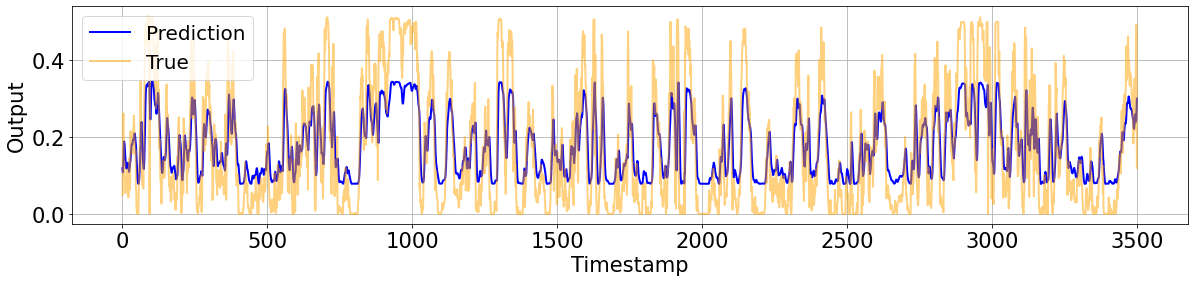

In [7]:
turbine = 30   # every node, e.g. with the sample data index range [0-59] can be retrieved here

preds = np.asarray([pred[turbine].detach().numpy() for pred in predictions])
labs  = np.asarray([label[turbine].numpy() for label in labels])

plt.figure(figsize=(20,4))
plt.xlabel("Timestamp", size=21)
plt.ylabel("Output", size=21)
plt.plot(preds, label="Prediction",color="blue", linewidth=2)
plt.plot(labs, label="True", color="orange", linewidth=2, alpha=0.5)
lgd = plt.legend(loc="upper left",prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=21)
plt.grid()
plt.show()

# Visualize every turbine

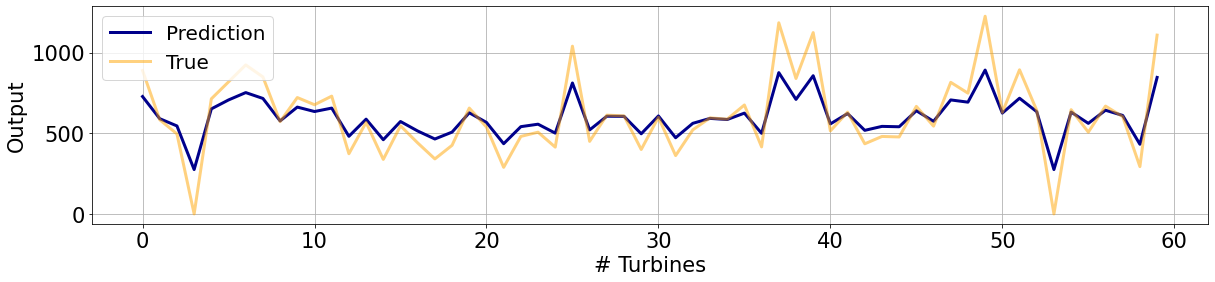

In [8]:
p_agg = np.sum([pred.detach().numpy() for pred in predictions], axis=0)
l_agg = np.sum([lab.detach().numpy() for lab in labels], axis=0)

plt.figure(figsize=(20,4))
plt.xlabel("# Turbines", size=21)
plt.ylabel("Output", size=21)
plt.plot(p_agg, label="Prediction",color="darkblue", linewidth=3)
plt.plot(l_agg, label="True", color="orange", linewidth=3, alpha=0.5)
lgd = plt.legend(loc="upper left",prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=21)
plt.grid()
plt.show()

# Visualize each timestamp

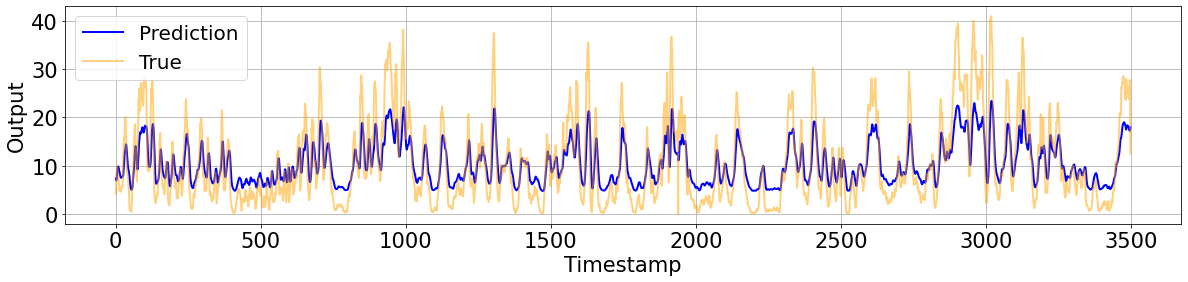

In [9]:
p_agg_t = np.sum([pred.detach().numpy() for pred in predictions], axis=1)
l_agg_t = np.sum([lab.detach().numpy() for lab in labels], axis=1)

plt.figure(figsize=(20,4))
plt.xlabel("Timestamp", size=21)
plt.ylabel("Output", size=21)
plt.plot(p_agg_t, label="Prediction",color="blue", linewidth=2)
plt.plot(l_agg_t, label="True", color="orange", linewidth=2, alpha=0.5)
lgd = plt.legend(loc="upper left",prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=21)
plt.grid()
plt.show()